Replicate the corrected version of Muchlinksi et al. (2016). Specifically you should make the separation plots (Fig 1), ROC curves (Fig 2), F1-scores (Fig 3), and Table 1 for the main models in the paper.

In [5]:
library(randomForest)
library(caret)
library(ROCR)
library(pROC)
library(stepPlr)
library(doMC)
library(xtable)

## Load data

In [7]:
pred_data <- read.csv(file="./data/SambanisImp.csv")
causal_mech_data <- read.csv(file="./data/Amelia.Imp3.csv")

In [8]:
# Using only the 88 variables specified in Sambanis (2006) Appendix
pred_data.full <- pred_data[,
    c("warstds", "ager", "agexp", "anoc", "army85", "autch98", "auto4",
      "autonomy", "avgnabo", "centpol3", "coldwar", "decade1", "decade2",
      "decade3", "decade4", "dem", "dem4", "demch98", "dlang", "drel",
      "durable", "ef", "ef2", "ehet", "elfo", "elfo2", "etdo4590",
      "expgdp", "exrec", "fedpol3", "fuelexp", "gdpgrowth", "geo1", "geo2",
      "geo34", "geo57", "geo69", "geo8", "illiteracy", "incumb", "infant",
      "inst", "inst3", "life", "lmtnest", "ln_gdpen", "lpopns", "major", "manuexp", "milper",
      "mirps0", "mirps1", "mirps2", "mirps3", "nat_war", "ncontig",
      "nmgdp", "nmdp4_alt", "numlang", "nwstate", "oil", "p4mchg",
      "parcomp", "parreg", "part", "partfree", "plural", "plurrel",
      "pol4", "pol4m", "pol4sq", "polch98", "polcomp", "popdense",
      "presi", "pri", "proxregc", "ptime", "reg", "regd4_alt", "relfrac", "seceduc",
      "second", "semipol3", "sip2", "sxpnew", "sxpsq", "tnatwar", "trade",
      "warhist", "xconst")]

In [10]:
# Convert DV into Factor with names for Caret Library
pred_data.full$warstds <- factor(
    pred_data.full$warstds,
    levels=c(0,1),
    labels=c("peace", "war"))

## Train models

In [11]:
# distribute workload over multiple cores for faster computation
registerDoMC(cores=7)
set.seed(666)

In [12]:
# cross-validation function for the Caret Library
tc <- trainControl(method="cv",
    number=10,
    summaryFunction=twoClassSummary,
    classProb=T,
    savePredictions=T)

### Fearon and Laitin Model (2003)

In [13]:
model.fl.1 <- train(
    as.factor(warstds)~warhist+ln_gdpen+lpopns+lmtnest+ncontig+oil+nwstate
                      +inst3+pol4+ef+relfrac, #FL 2003 model spec
    metric="ROC", method="glm", family="binomial",
    trControl=tc, data=pred_data.full)

In [14]:
summary(model.fl.1)


Call:
NULL

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.0635  -0.1859  -0.1325  -0.0994   3.2962  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -8.46582    1.11539  -7.590 3.20e-14 ***
warhist      0.02247    0.25379   0.089  0.92946    
ln_gdpen    -0.35196    0.11791  -2.985  0.00284 ** 
lpopns       0.18788    0.06815   2.757  0.00584 ** 
lmtnest      0.18706    0.08049   2.324  0.02013 *  
ncontig      0.26477    0.28232   0.938  0.34831    
oil          0.33689    0.30155   1.117  0.26391    
nwstate      1.86032    0.32037   5.807 6.37e-09 ***
inst3        1.36212    0.20709   6.577 4.79e-11 ***
pol4        -0.02435    0.01781  -1.367  0.17170    
ef           0.44421    0.42340   1.049  0.29411    
relfrac      0.59413    0.50782   1.170  0.24202    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1185.9  on 7139  degrees 

### Fearon and Laitin Model (2003) penalized logistic regression

In [16]:
model.fl.2 <- train(
    as.factor(warstds)~warhist+ln_gdpen+lpopns+lmtnest+ncontig+oil+nwstate
                      +inst3+pol4+ef+relfrac, #FL 2003 model spec
    metric="ROC", method="plr",
    trControl=tc, data=pred_data.full)

In [17]:
summary(model.fl.2)


Call:
stepPlr::plr(x = x, y = y, weights = if (!is.null(wts)) wts else rep(1, 
    length(y)), lambda = param$lambda, cp = as.character(param$cp))

Coefficients:
          Estimate Std.Error z value Pr(>|z|)
Intercept  8.46578   1.11547   7.589    0.000
warhist   -0.02246   0.25380  -0.088    0.930
ln_gdpen   0.35197   0.11791   2.985    0.003
lpopns    -0.18788   0.06816  -2.756    0.006
lmtnest   -0.18705   0.08050  -2.324    0.020
ncontig   -0.26477   0.28233  -0.938    0.348
oil       -0.33688   0.30156  -1.117    0.264
nwstate   -1.86028   0.32038  -5.806    0.000
inst3     -1.36210   0.20710  -6.577    0.000
pol4       0.02435   0.01782   1.366    0.172
ef        -0.44420   0.42340  -1.049    0.294
relfrac   -0.59410   0.50783  -1.170    0.242

    Null deviance: 1185.92 on 7139 degrees of freedom
Residual deviance: 1057.19 on 7128 degrees of freedom
            Score: deviance + 8.9 * df = 1163.67 


### Collier and Hoeffler Model (2004) 


In [20]:
model.ch.1 <- train(
    as.factor(warstds)~sxpnew+sxpsq+ln_gdpen+gdpgrowth+warhist+lmtnest+ef+popdense
                      +lpopns+coldwar+seceduc+ptime,
    metric="ROC", method="glm", family="binomial",
    trControl=tc, data=pred_data.full)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


In [21]:
summary(model.ch.1)


Call:
NULL

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.1130  -0.1837  -0.1161  -0.0777   3.5875  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -6.945e+00  1.251e+00  -5.550 2.86e-08 ***
sxpnew       1.768e+01  4.288e+00   4.123 3.74e-05 ***
sxpsq       -7.685e+01  1.125e+01  -6.831 8.42e-12 ***
ln_gdpen    -4.402e-01  1.418e-01  -3.104  0.00191 ** 
gdpgrowth   -6.783e+00  1.228e+00  -5.525 3.29e-08 ***
warhist     -5.266e-01  2.612e-01  -2.016  0.04378 *  
lmtnest      2.332e-01  8.192e-02   2.846  0.00443 ** 
ef          -1.118e-02  4.446e-01  -0.025  0.97993    
popdense    -1.463e-04  9.093e-04  -0.161  0.87217    
lpopns       2.265e-01  6.922e-02   3.272  0.00107 ** 
coldwar     -1.081e-01  2.678e-01  -0.404  0.68642    
seceduc     -5.562e-03  5.650e-03  -0.984  0.32490    
ptime       -2.279e-03  7.607e-04  -2.996  0.00273 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter

### Collier and Hoeffler (2004) penalized logistic regression

In [22]:
model.ch.2 <- train(
    as.factor(warstds)~sxpnew+sxpsq+ln_gdpen+gdpgrowth+warhist+lmtnest+ef+popdense
                      +lpopns+coldwar+seceduc+ptime,
    metric="ROC", method="plr",
    trControl=tc, data=pred_data.full)


Convergence warning in plr: 2 


In [23]:
summary(model.ch.2)


Call:
stepPlr::plr(x = x, y = y, weights = if (!is.null(wts)) wts else rep(1, 
    length(y)), lambda = param$lambda, cp = as.character(param$cp))

Coefficients:
          Estimate Std.Error z value Pr(>|z|)
Intercept  5.67881   1.18772   4.781    0.000
sxpnew     5.81691   4.79867   1.212    0.226
sxpsq      3.82190  11.05193   0.346    0.729
ln_gdpen   0.39527   0.12803   3.087    0.002
gdpgrowth  5.86988   1.26353   4.646    0.000
warhist    0.16942   0.25902   0.654    0.513
lmtnest   -0.17228   0.07806  -2.207    0.027
ef        -0.29777   0.43436  -0.686    0.493
popdense   0.00105   0.00117   0.897    0.370
lpopns    -0.17755   0.06703  -2.649    0.008
coldwar    0.01218   0.26422   0.046    0.963
seceduc    0.00850   0.00556   1.529    0.126
ptime      0.00113   0.00072   1.569    0.117

    Null deviance: 1185.92 on 7139 degrees of freedom
Residual deviance: 1052.69 on 7127.03 degrees of freedom
            Score: deviance + 8.9 * df = 1167.77 


### Hegre and Sambanis (2006) Model 

In [24]:
model.hs.1 <- train(
    warstds~lpopns+ln_gdpen+inst3+parreg+geo34+proxregc+gdpgrowth+anoc
           +partfree+nat_war+lmtnest+decade1+pol4sq+nwstate+regd4_alt+etdo4590+milper
           +geo1+tnatwar+presi,
    metric="ROC", method="glm", family="binomial",
    trControl=tc, data=pred_data.full)

In [25]:
summary(model.hs.1)


Call:
NULL

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.3271  -0.1876  -0.1212  -0.0719   3.7643  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -7.882e+00  1.336e+00  -5.901 3.62e-09 ***
lpopns       2.314e-01  7.381e-02   3.135  0.00172 ** 
ln_gdpen    -2.978e-01  1.318e-01  -2.259  0.02386 *  
inst3        1.410e+00  2.476e-01   5.694 1.24e-08 ***
parreg      -2.933e-01  1.364e-01  -2.151  0.03151 *  
geo34       -1.062e-01  3.163e-01  -0.336  0.73709    
proxregc    -9.256e-01  3.118e-01  -2.968  0.00300 ** 
gdpgrowth   -6.224e+00  1.209e+00  -5.148 2.63e-07 ***
anoc         4.359e-01  3.037e-01   1.435  0.15119    
partfree     9.320e-02  2.734e-01   0.341  0.73315    
nat_war      1.000e+00  3.119e-01   3.206  0.00134 ** 
lmtnest      1.652e-01  7.996e-02   2.066  0.03883 *  
decade1      1.870e-01  2.563e-01   0.729  0.46574    
pol4sq       2.510e-03  5.606e-03   0.448  0.65428    
nwstate      1.872e+00  3.526e-01 

### Hegre and Sambanis (2006) penalized logistic regression

In [26]:
model.hs.2 <- train(
    warstds~lpopns+ln_gdpen+inst3+parreg+geo34+proxregc+gdpgrowth+anoc
           +partfree+nat_war+lmtnest+decade1+pol4sq+nwstate+regd4_alt+etdo4590+milper
           +geo1+tnatwar+presi,
    metric="ROC", method="plr",
    trControl=tc, data=pred_data.full)


Convergence warning in plr: 2 


In [27]:
summary(model.hs.2)


Call:
stepPlr::plr(x = x, y = y, weights = if (!is.null(wts)) wts else rep(1, 
    length(y)), lambda = param$lambda, cp = as.character(param$cp))

Coefficients:
          Estimate Std.Error z value Pr(>|z|)
Intercept  6.25432   1.29731   4.821    0.000
lpopns    -0.15150   0.07278  -2.082    0.037
ln_gdpen   0.30287   0.13040   2.323    0.020
inst3     -1.41801   0.24490  -5.790    0.000
parreg     0.35119   0.13266   2.647    0.008
geo34      0.11886   0.31104   0.382    0.702
proxregc   0.91898   0.30716   2.992    0.003
gdpgrowth  4.92304   1.27157   3.872    0.000
anoc      -0.34813   0.29985  -1.161    0.246
partfree  -0.06085   0.27020  -0.225    0.822
nat_war   -1.01204   0.30950  -3.270    0.001
lmtnest   -0.16654   0.07871  -2.116    0.034
decade1   -0.15392   0.25488  -0.604    0.546
pol4sq    -0.00097   0.00555  -0.175    0.861
nwstate   -1.85766   0.34810  -5.337    0.000
regd4_alt  0.05437   0.02823   1.926    0.054
etdo4590   0.01112   0.22645   0.049    0.961
milper   

### Random Forest

In [28]:
model.rf <- train(
    as.factor(warstds)~.,
    metric="ROC", method="rf",
    sampsize=c(30,90),
    importance=T,
    proximity=F, 
    ntree=1000,
    trControl=tc, data=pred_data.full)

In [29]:
summary(model.rf)

                Length Class      Mode     
call                8  -none-     call     
type                1  -none-     character
predicted        7140  factor     numeric  
err.rate         3000  -none-     numeric  
confusion           6  -none-     numeric  
votes           14280  matrix     numeric  
oob.times        7140  -none-     numeric  
classes             2  -none-     character
importance        360  -none-     numeric  
importanceSD      270  -none-     numeric  
localImportance     0  -none-     NULL     
proximity           0  -none-     NULL     
ntree               1  -none-     numeric  
mtry                1  -none-     numeric  
forest             14  -none-     list     
y                7140  factor     numeric  
test                0  -none-     NULL     
inbag               0  -none-     NULL     
xNames             90  -none-     character
problemType         1  -none-     character
tuneValue           1  data.frame list     
obsLevels           2  -none-   

## Figure 2 (ROC Curves)

In [30]:
pred.FL.war<-model.fl.1$finalModel$fitted.values
pred.CH.war<-model.ch.1$finalModel$fitted.values
pred.HR.war<-model.hs.1$finalModel$fitted.values

In [31]:
RF.1.pred<-predict(model.rf$finalModel, type="prob")
RF.1.pred<-as.data.frame(RF.1.pred)

In [33]:
pred.FL <- prediction(pred.FL.war, pred_data.full$warstds)
perf.FL <- performance(pred.FL,"tpr","fpr")
pred.CH <- prediction(pred.CH.war, pred_data.full$warstds)
perf.CH <- performance(pred.CH,"tpr","fpr")
pred.HS<-prediction(pred.HR.war, pred_data.full$warstds)
perf.HS<-performance(pred.HS, "tpr", "fpr")
pred.RF.1<-prediction(RF.1.pred$war, pred_data.full$warstds)
perf.RF.1<-performance(pred.RF.1, "tpr", "fpr")

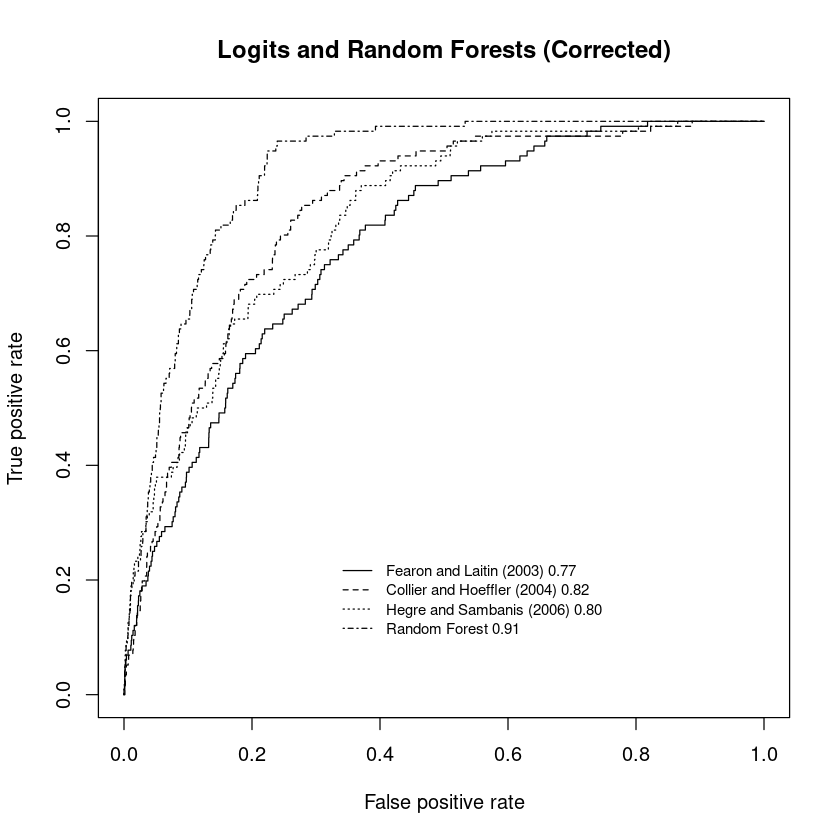

In [39]:
plot(perf.FL, main="Logits and Random Forests (Corrected)")
plot(perf.CH, add=T, lty=2)
plot(perf.HS, add=T, lty=3)
plot(perf.RF.1, add=T, lty=4)
legend(0.32, 0.25, 
       c("Fearon and Laitin (2003) 0.77", "Collier and Hoeffler (2004) 0.82",
         "Hegre and Sambanis (2006) 0.80", "Random Forest 0.91" ),
       lty=c(1,2,3,4), bty="n", cex = .75)

In [36]:
FL.2.pred<-1-model.fl.2$finalModel$fitted.values
CH.2.pred<-1-model.ch.2$finalModel$fitted.values
HS.2.pred<-1-model.hs.2$finalModel$fitted.values

In [37]:
pred.FL.2 <- prediction(FL.2.pred, pred_data.full$warstds)
perf.FL.2 <- performance(pred.FL.2,"tpr","fpr")
pred.CH.2<- prediction(CH.2.pred, pred_data.full$warstds)
perf.CH.2 <- performance(pred.CH.2,"tpr","fpr")
pred.HS.2<- prediction(HS.2.pred, pred_data.full$warstds)
perf.HS.2 <- performance(pred.HS.2,"tpr","fpr")

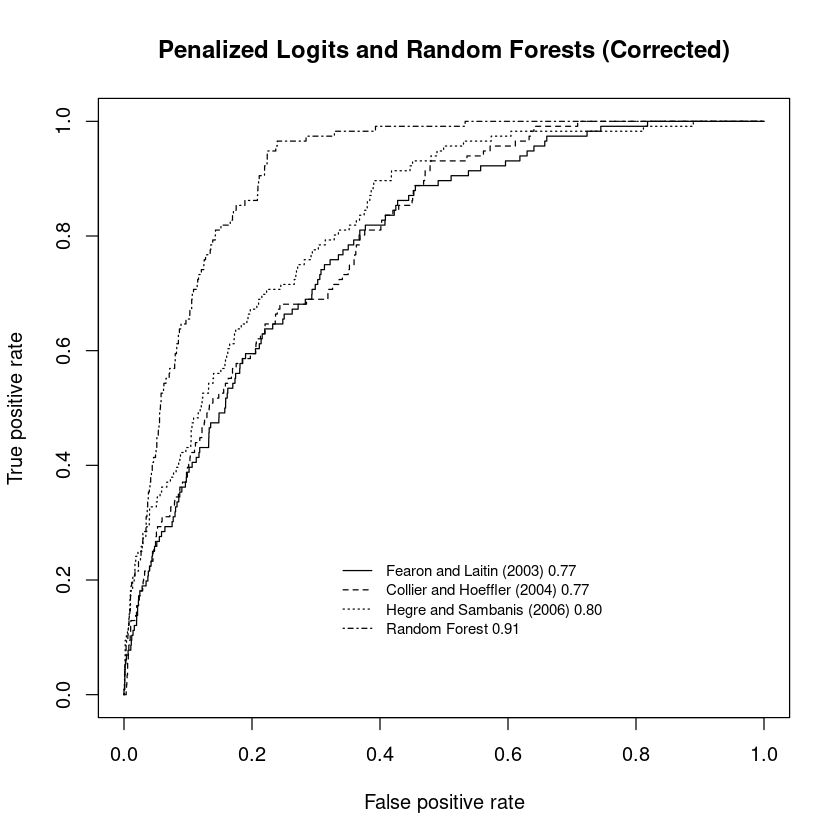

In [38]:
plot(perf.FL.2, main="Penalized Logits and Random Forests (Corrected)")
plot(perf.CH.2, add=T, lty=2)
plot(perf.HS.2, add=T, lty=3)
plot(perf.RF.1, add=T, lty=4)
legend(0.32, 0.25, 
       c("Fearon and Laitin (2003) 0.77",
         "Collier and Hoeffler (2004) 0.77",
         "Hegre and Sambanis (2006) 0.80",
         "Random Forest 0.91" ), 
       lty=c(1,2,3,4), bty="n", cex = .75)

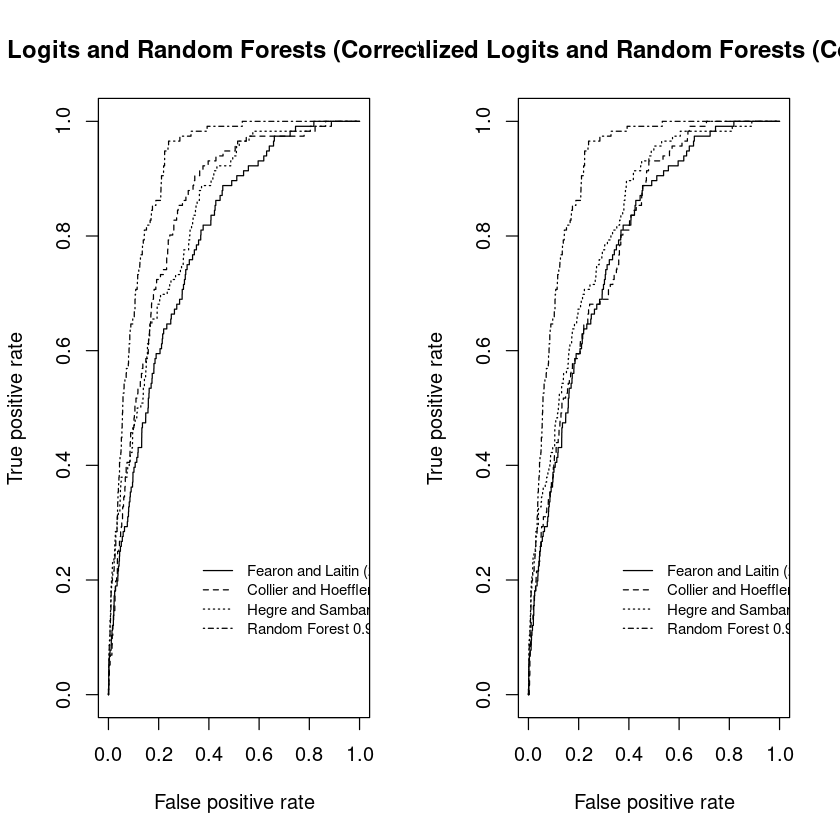

In [40]:
### Combine both ROC plots
par(mfrow=c(1,2))
plot(perf.FL, main="Logits and Random Forests (Corrected)")
plot(perf.CH, add=T, lty=2)
plot(perf.HS, add=T, lty=3)
plot(perf.RF.1, add=T, lty=4)
legend(0.32, 0.25, 
       c("Fearon and Laitin (2003) 0.77", "Collier and Hoeffler (2004) 0.82",
         "Hegre and Sambanis (2006) 0.80", "Random Forest 0.91" ),
       lty=c(1,2,3,4), bty="n", cex = .75)
plot(perf.FL.2, main="Penalized Logits and Random Forests (Corrected)")
plot(perf.CH.2, add=T, lty=2)
plot(perf.HS.2, add=T, lty=3)
plot(perf.RF.1, add=T, lty=4)
legend(0.32, 0.25,
       c("Fearon and Laitin (2003) 0.77", "Collier and Hoeffler (2004) 0.77",
         "Hegre and Sambanis (2006) 0.80", "Random Forest 0.91" ),
       lty=c(1,2,3,4), bty="n", cex = .75)

## Figure 1 (separation plots)

In [41]:
library(separationplot)

ERROR: Error in library(separationplot): there is no package called ‘separationplot’


## Figure 3

## Table 1